In [1]:
from collections import Counter, defaultdict
import numpy as np
from scipy import misc, linalg
from imp import reload
from labfuns import *
import random
from math import log, exp

In [2]:
def computePrior(labels, W=None):
    """
    param labels: N vector of class labels.
    return: prior - C x 1 vector of class priors
    """
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses,1))

    for class_idx, class_ in enumerate(classes):
        wlc = W[np.where(labels==class_)[0],:]
        #prior[class_idx] = np.where(labels==class_)[0].shape[0]/Npts
        prior[class_idx] = (wlc.sum(axis=0))

    return prior

In [3]:
def mlParams(X, labels, W=None):
    """
    param X: N x d matrix of N data points
    param labels: N vector of class labels
    return: mu - C x d matrix of class means (mu[i] - class i mean)
    return: sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
    """
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)
    
    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))

    for class_idx, (class_, W_) in enumerate(zip(classes, W)):
        idx = np.where(labels==class_)[0] # Extract the indices for which y==class is true,
        xlc = X[idx,:]
        wlc = W[idx,:]
        mu[class_idx] = sum([wi*xi for wi,xi in zip(wlc, xlc)])/ wlc.sum(axis=0)
        #mu[class_idx] = xlc.sum(axis=0) / len(xlc)
        
        for dim_idx in range(Ndims):
            var = 0
            for class_vect, W_value in zip(xlc, wlc):
                var += (W_value*(class_vect[dim_idx] - mu[class_idx][dim_idx])**2)
            var = var / wlc.sum(axis=0)
#               var += (class_vect[dim_idx] - mu[class_idx][dim_idx])**2
#           var = var / len(xlc)
            sigma[class_idx, dim_idx, dim_idx] = var

    return mu, sigma

In [4]:
def classifyBayes(X, prior, mu, sigma):
    """
    param X: N x d matrix of M data points
    param prior: C x 1 matrix of class priors
    param mu: C x d matrix of class means (mu[i] - class i mean)
    param sigma: C x d x d matrix of class covariances (sigma[i] - class i sigma)
    returns: h N vector of class predictions for test points
    """
    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))   
    
    for data_idx, data_vector in enumerate(X):
        prediction_vector = []
        
        for class_idx, (class_prior, class_mu, class_sigma) in enumerate(zip(prior, mu, sigma)):
            first_term = -0.5*(np.log(abs(class_sigma.diagonal().prod()))) 
            third_term = np.log(class_prior)
            inverse_sum_term = 0
            
            for vector_value, diag_value, mu_value in zip(data_vector, class_sigma.diagonal(), class_mu):
                inverse_sum_term += ((vector_value - mu_value)**2) / (2*diag_value)
            discriminant_function = first_term - inverse_sum_term + third_term
            logProb[class_idx, data_idx] = discriminant_function
    
    h = np.argmax(logProb,axis=0)
          
    return h

In [5]:
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

In [6]:
def recall_accuracy(predictions, labels):
    ground_truth_and_prediction_by_class = defaultdict(list)
    correct_count_by_class = defaultdict(int)
    prediction_and_ground_truth_by_class = defaultdict(list)
    correct_count_by_prediction_class = defaultdict(int) 

    for prediction_idx, prediction in enumerate(predictions):
    #ground_truth_and_prediction_by_class[ground_truth].append(predictions[ground_truth_idx])
        prediction_and_ground_truth_by_class[prediction].append((prediction, labels[prediction_idx]))
        if prediction == labels[prediction_idx]:
            correct_count_by_prediction_class[prediction] += 1

    for ground_truth_idx, ground_truth in enumerate(labels):
    #ground_truth_and_prediction_by_class[ground_truth].append(predictions[ground_truth_idx])
        ground_truth_and_prediction_by_class[ground_truth].append((ground_truth,predictions[ground_truth_idx]))
        if ground_truth == predictions[ground_truth_idx]:
            correct_count_by_class[ground_truth] += 1
    print('Accuracy')
    print(correct_count_by_prediction_class)
    #accuracy
    for class_val, class_corr_count in correct_count_by_prediction_class.items():
        print(f'{class_val}: {class_corr_count / len(prediction_and_ground_truth_by_class[class_val])}')
              
    print('Recall')
    print(correct_count_by_class)
    #recall
    for class_val, class_corr_count in correct_count_by_class.items():
        print(f'{class_val}: {class_corr_count / len(ground_truth_and_prediction_by_class[class_val])}')

#test==labels_iris
#counter = Counter(test==labels_iris)    

In [7]:
def trainBoost(base_classifier, X, labels, T=10):
    """
    param base_classifier: a classifier of the type that we will boost, e.g. BayesClassifier
    param X:  N x d matrix of N data points
    param labels: N vector of class labels
    param T: number of boosting iterations
    return: classifiers - (maximum) length T Python list of trained classifiers
    return: alphas - (maximum) length T Python list of vote weights
    """
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        # e.g BayesClassifier().trainClassifier(X, labels, wCur) will return rtn.
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        #classify(X) returns classifyBayes(X, self.prior, self.mu, self.sigma) 
        #=> h (N vector of class predictions for test points)
        vote = classifiers[-1].classify(X)
        e_t = 1e-15
        
        for w_i, x_i_label, x_i_prediction in zip(wCur, labels, vote):
            if x_i_label != x_i_prediction:
                e_t += w_i
            if x_i_label == x_i_prediction:
                pass
#         print(f'check eps: {e_t}')
#         print(type(e_t))
#         e_t = np.float64(e_t) + 1e-15
#         print(type(e_t))
#         print(e_t)
        
        alpha = (np.log(1 - e_t) - np.log(e_t)) / 2.
        alphas.append(alpha)
        
#         Z =  e_t * exp(alpha) + exp(-alpha) * (1 - e_t)     
        for instance_idx, (w_i, x_i_label, x_i_prediction) in enumerate(zip(wCur, labels, vote)):
            if x_i_label != x_i_prediction:
                wCur[instance_idx] = (w_i * exp(alpha))# / Z
            else:
                wCur[instance_idx] = (w_i * exp(-alpha))# / Z
        
        wCur = wCur / np.sum(wCur)
    
    return classifiers, alphas

In [8]:
def classifyBoost(X, classifiers, alphas, Nclasses):
    """
    param X: N x d matrix of N data points
    param classifiers: (maximum) length T Python list of trained classifiers as above
    param alphas: (maximum) length T Python list of vote weights
    param Nclasses: the number of different classes
    return:  yPred - N vector of class predictions for test points
    """
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    
    else:
        votes = np.zeros((Npts,Nclasses))
        
        for t in range(Ncomps):
            classifiers_ = classifiers[t].classify(X)
            #print(classifiers_)
            for i in range(Npts):
                votes[i,classifiers_[i]] += alphas[t]

        return  np.argmax(votes,axis=1)

In [9]:
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

In [10]:
# every time I predicted a 0 92% of the times was correct, 76% was correct when class 1 was predicted 
# 90% of the times class 2 was predicted was correct.

X_iris, labels_iris, pcadim_iris = fetchDataset('iris')
X_vowel, labels_vowel, pcadim_vowel = fetchDataset('vowel')

mu_iris, sigma_iris = mlParams(X_iris, labels_iris)
mu_vowel, sigma_vowel = mlParams(X_vowel, labels_vowel)

prior_iris = computePrior(labels_iris)
prior_vowel = computePrior(labels_vowel)

predictions_iris = classifyBayes(X_iris, prior_iris, mu_iris, sigma_iris)
predictions_vowel = classifyBayes(X_vowel ,prior_vowel, mu_vowel, sigma_vowel)

recall_accuracy(predictions_iris, labels_iris)


Accuracy
defaultdict(<class 'int'>, {0: 50, 1: 47, 2: 47})
0: 1.0
1: 0.94
2: 0.94
Recall
defaultdict(<class 'int'>, {0: 50, 1: 47, 2: 47})
0: 1.0
1: 0.94
2: 0.94


In [11]:
recall_accuracy(predictions_vowel, labels_vowel)

Accuracy
defaultdict(<class 'int'>, {2: 44, 4: 40, 7: 35, 8: 23, 10: 36, 1: 35, 3: 36, 6: 34, 0: 34, 5: 30, 9: 34})
2: 0.8979591836734694
4: 0.6896551724137931
7: 0.8536585365853658
8: 0.575
10: 0.6545454545454545
1: 0.7954545454545454
3: 0.8372093023255814
6: 0.68
0: 0.8095238095238095
5: 0.7894736842105263
9: 0.5
Recall
defaultdict(<class 'int'>, {2: 44, 4: 40, 7: 35, 8: 23, 10: 36, 1: 35, 3: 36, 6: 34, 0: 34, 5: 30, 9: 34})
2: 0.9166666666666666
4: 0.8333333333333334
7: 0.7291666666666666
8: 0.4791666666666667
10: 0.75
1: 0.7291666666666666
3: 0.75
6: 0.7083333333333334
0: 0.7083333333333334
5: 0.625
9: 0.7083333333333334


> ## Test the Maximum Likelihood estimates
Call `genBlobs` and `plotGaussian` to verify your estimates.

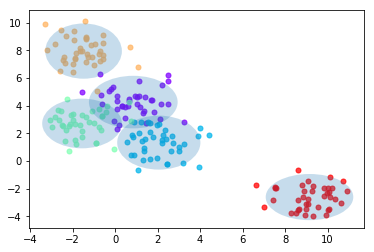

In [12]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

> Call the `testClassifier` and `plotBoundary` functions for this part.

In [13]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 84.4
Trial: 10 Accuracy 95.6
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 86.7
Trial: 40 Accuracy 88.9
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 86.7
Trial: 70 Accuracy 91.1
Trial: 80 Accuracy 86.7
Trial: 90 Accuracy 91.1
Final mean classification accuracy  89 with standard deviation 4.16


In [14]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 61
Trial: 10 Accuracy 66.2
Trial: 20 Accuracy 74
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 64.3
Trial: 60 Accuracy 66.9
Trial: 70 Accuracy 63.6
Trial: 80 Accuracy 62.3
Trial: 90 Accuracy 70.8
Final mean classification accuracy  64.7 with standard deviation 4.03


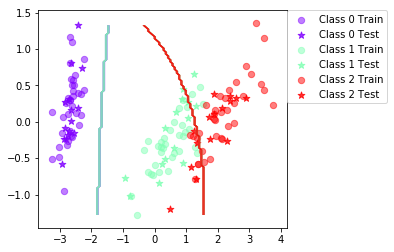

In [18]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)

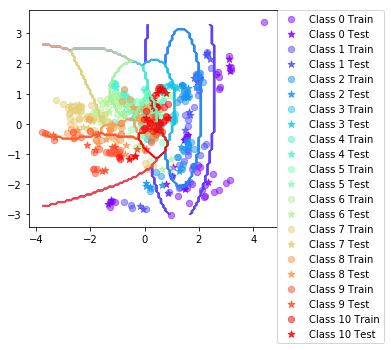

In [19]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='vowel',split=0.7)

> ## Boosting functions to implement
The lab descriptions state what each function should do.

> The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

> ## Run some experiments
Call the `testClassifier` and `plotBoundary` functions for this part.

In [20]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 93.3
Trial: 60 Accuracy 93.3
Trial: 70 Accuracy 97.8
Trial: 80 Accuracy 95.6
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.7 with standard deviation 2.82


In [21]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 76.6
Trial: 10 Accuracy 86.4
Trial: 20 Accuracy 83.1
Trial: 30 Accuracy 80.5
Trial: 40 Accuracy 72.7
Trial: 50 Accuracy 76
Trial: 60 Accuracy 81.8
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 79.9
Trial: 90 Accuracy 83.1
Final mean classification accuracy  80.2 with standard deviation 3.52


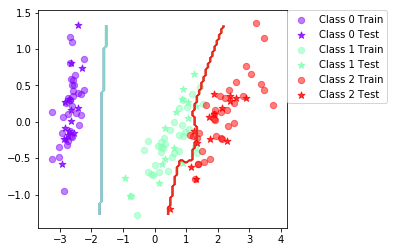

In [22]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


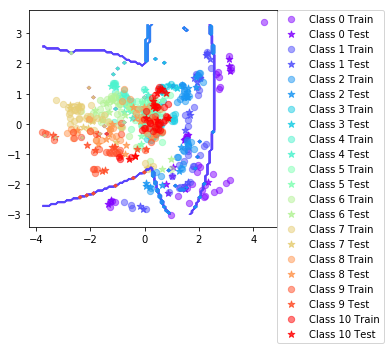

In [23]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='vowel',split=0.7)

> Now repeat the steps with a decision tree classifier.

In [24]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 91.1
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 91.1
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 88.9
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 88.9
Final mean classification accuracy  92.4 with standard deviation 3.71


In [25]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

Trial: 0 Accuracy 95.6
Trial: 10 Accuracy 100
Trial: 20 Accuracy 95.6
Trial: 30 Accuracy 91.1
Trial: 40 Accuracy 93.3
Trial: 50 Accuracy 95.6
Trial: 60 Accuracy 88.9
Trial: 70 Accuracy 93.3
Trial: 80 Accuracy 93.3
Trial: 90 Accuracy 93.3
Final mean classification accuracy  94.6 with standard deviation 3.67


In [26]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

Trial: 0 Accuracy 63.6
Trial: 10 Accuracy 68.8
Trial: 20 Accuracy 63.6
Trial: 30 Accuracy 66.9
Trial: 40 Accuracy 59.7
Trial: 50 Accuracy 63
Trial: 60 Accuracy 59.7
Trial: 70 Accuracy 68.8
Trial: 80 Accuracy 59.7
Trial: 90 Accuracy 68.2
Final mean classification accuracy  64.1 with standard deviation 4


In [27]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

Trial: 0 Accuracy 87
Trial: 10 Accuracy 90.3
Trial: 20 Accuracy 87
Trial: 30 Accuracy 90.9
Trial: 40 Accuracy 85.7
Trial: 50 Accuracy 80.5
Trial: 60 Accuracy 89.6
Trial: 70 Accuracy 87.7
Trial: 80 Accuracy 86.4
Trial: 90 Accuracy 86.4
Final mean classification accuracy  86.7 with standard deviation 2.87


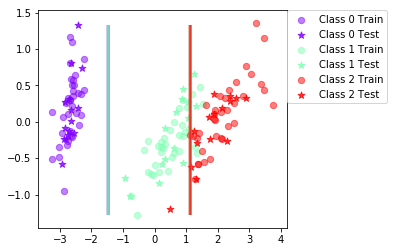

In [28]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

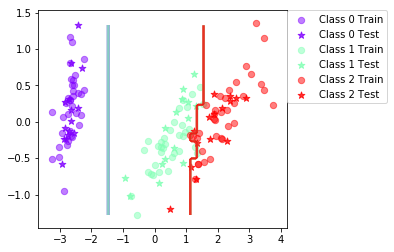

In [29]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


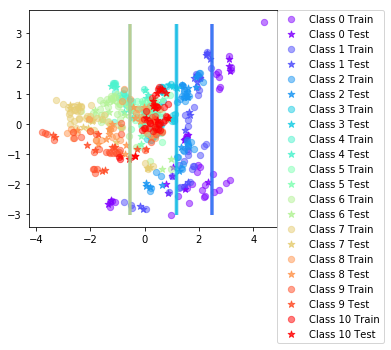

In [30]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='vowel',split=0.7)

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


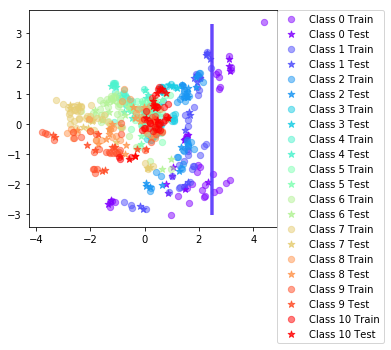

In [31]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

> ## Bonus: Visualize faces classified using boosted decision trees
Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [32]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.8
Trial: 20 Accuracy 85
Trial: 30 Accuracy 89.2
Trial: 40 Accuracy 89.2
Trial: 50 Accuracy 84.2
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 81.7
Trial: 90 Accuracy 86.7
Final mean classification accuracy  87.7 with standard deviation 3.03


In [35]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 88.3
Trial: 10 Accuracy 90.8
Trial: 20 Accuracy 85
Trial: 30 Accuracy 89.2
Trial: 40 Accuracy 89.2
Trial: 50 Accuracy 85
Trial: 60 Accuracy 91.7
Trial: 70 Accuracy 82.5
Trial: 80 Accuracy 80
Trial: 90 Accuracy 86.7
Final mean classification accuracy  87.5 with standard deviation 3.12


In [34]:
testClassifier(DecisionTreeClassifier(), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 65.8
Trial: 10 Accuracy 57.5
Trial: 20 Accuracy 49.2
Trial: 30 Accuracy 50
Trial: 40 Accuracy 53.3
Trial: 50 Accuracy 44.2
Trial: 60 Accuracy 49.2
Trial: 70 Accuracy 54.2
Trial: 80 Accuracy 50
Trial: 90 Accuracy 52.5
Final mean classification accuracy  48.4 with standard deviation 6.45


In [36]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

Trial: 0 Accuracy 68.3
Trial: 10 Accuracy 70
Trial: 20 Accuracy 80
Trial: 30 Accuracy 67.5
Trial: 40 Accuracy 71.7
Trial: 50 Accuracy 65
Trial: 60 Accuracy 70
Trial: 70 Accuracy 70
Trial: 80 Accuracy 50.8
Trial: 90 Accuracy 75
Final mean classification accuracy  69.7 with standard deviation 6.87


> You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

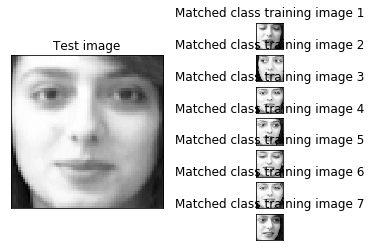

In [60]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data np.size(np.unique(y)) = 40
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])

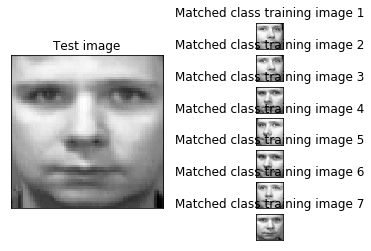

In [42]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(BayesClassifier()).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])